# Actor-Critic (Monte Carlo): Adding Baselines to Reduce Variance

## 🎯 The Variance Problem in REINFORCE

From our REINFORCE experiments, we observed **extremely high variance** in gradient estimates. The same action taken in similar states could receive vastly different return signals depending on random episode outcomes. This makes learning unstable and slow.

**The Core Issue**: $\nabla J(\theta) = \mathbb{E}[\nabla \log \pi_\theta(a_t|s_t) \cdot G_t]$

Where $G_t$ (episode return) has **huge variance** because:
- Episode outcomes depend on many future actions and environment randomness
- One crash late in the episode ruins the signal for all earlier actions
- No consideration of "typical" performance - each episode is treated independently

## 🧠 Actor-Critic: The Baseline Solution

**Actor-Critic** methods solve the variance problem by introducing a **baseline** - a reference point that doesn't change the expected gradient but reduces variance.

### Mathematical Foundation: Baseline Invariance

**Key Theorem**: For any baseline $b(s_t)$ that doesn't depend on the action $a_t$:

$$\mathbb{E}[\nabla \log \pi_\theta(a_t|s_t) \cdot b(s_t)] = 0$$

This means we can subtract any state-dependent baseline from our returns without changing the expected gradient:

$$\nabla J(\theta) = \mathbb{E}[\nabla \log \pi_\theta(a_t|s_t) \cdot (G_t - b(s_t))]$$

**Intuition**: The baseline serves as a "reference point" - we only reinforce actions that performed **better than expected**.

## 🏗️ Actor-Critic Architecture

Actor-Critic methods consist of two components:

### 👤 Actor (Policy Network)
- **Purpose**: Choose actions based on current state
- **Output**: Policy distribution $\pi_\theta(a|s)$
- **Training**: Updated using policy gradient with baseline-reduced variance
- **Same as REINFORCE**: Uses log-probability gradients

### 🎭 Critic (Value Network)  
- **Purpose**: Estimate state values to serve as baseline
- **Output**: State value estimate $V_\phi(s)$
- **Training**: Minimize mean squared error with actual returns
- **New Component**: This is what REINFORCE lacks!

### 🔗 Shared Network Architecture

Now we have both actor and critic neural networks, but we'll use a **shared architecture** design:

1. **Shared Feature Layer**: Both actor and critic share the first layer since they're processing the same observations and learning related representations
2. **Separate Heads**: After the shared features, we have separate branches for actor and critic outputs

**Architecture Configuration**:
```python
"fc_out_features": [64],    # Shared features (single layer)
"actor_features": [64],     # Actor-specific layers after shared
"critic_features": [64],    # Critic-specific layers after shared
```

**Why This Design?**
- **Feature Sharing**: Both networks benefit from shared low-level feature extraction
- **Specialization**: Separate heads allow each component to specialize in its task
- **Efficiency**: Reduces total parameter count compared to completely separate networks

### 📊 Fair Parameter Comparison with REINFORCE

To make a fair comparison with REINFORCE (which only learns the actor/policy network), we deliberately choose a parameter configuration that results in similar total parameter counts:

**REINFORCE Configuration**:
```python
"fc_out_features": [64, 64, 64],  # Three layers for policy network (~9,500 parameters)
```

**Actor-Critic Configuration**:
```python
"fc_out_features": [64],    # Shared features
"actor_features": [64],     # Actor branch  
"critic_features": [64],    # Critic branch
# Total: ~9,500 parameters (similar to REINFORCE)
```

**Parameter Breakdown**:
- **Shared layer**: Processes 8D observations → 64 features
- **Actor head**: 64 features → action outputs (4 discrete or 2 continuous)
- **Critic head**: 64 features → 1 value output
- **Total**: Approximately 9,500 parameters (matching REINFORCE for fair comparison)

This ensures that performance differences come from the **algorithmic improvements** (baselines, dual learning objectives) rather than simply having more model capacity.

## 🔄 Two Baseline Approaches

In this notebook, we'll implement **two different baseline strategies** to demonstrate the progression from simple to sophisticated variance reduction:

### Approach 1: Global Average Return Baseline ($\bar{G}$)

**Baseline**: $b = \bar{G} = \frac{1}{N} \sum_{i=1}^N G_0^{(i)}$

Where:
- $N$ = Total number of episodes experienced so far
- $i$ = Episode index (superscript denotes episode number)
- $G_0^{(i)}$ = Episode return starting from initial state of episode $i$

**Why $G_0$ specifically?**
- **Episode return**: $G_0^{(i)} = \sum_{k=0}^{T-1} \gamma^k r_{k+1}^{(i)}$ is the total discounted return for episode $i$
- **Initial state value**: We use $G_0$ (return from time step 0) because it represents the **total episode performance**
- **Global metric**: This single number summarizes how well the entire episode went
- **State-independent**: Same baseline value used for all states within any episode

**Mathematical Details**:
- **Running average**: $\bar{G} = \frac{1}{N} \sum_{i=1}^N G_0^{(i)}$ where $N$ increases with each completed episode
- **Updated after each episode**: $\bar{G}_{new} = \frac{(N-1) \cdot \bar{G}_{old} + G_0^{(N)}}{N}$
- **Applied to all timesteps**: For episode $i$, all timesteps use the same baseline: $b_t = \bar{G}$ for all $t$

**Characteristics**:
- **Simple running average** of all episode returns seen so far
- **State-independent**: Same baseline used for all states in all episodes
- **Easy to implement**: Just track episode return average
- **Limited effectiveness**: Doesn't account for state-specific expectations

### Approach 2: State-Dependent Value Function Baseline ($V(s_t)$)

**Baseline**: $b(s_t) = V_\phi(s_t)$

- **Learned value function** that estimates expected return from each state
- **State-dependent**: Different baseline for different states
- **More sophisticated**: Requires neural network and training
- **Better variance reduction**: Accounts for state-specific expectations

## 📊 Expected Learning Progression

We expect to see:

1. **Global Average Baseline**: Moderate variance reduction compared to REINFORCE
2. **Value Function Baseline**: Significant variance reduction and faster convergence
3. **Still Monte Carlo**: Both use full episode returns $G_t$ (no bootstrapping yet)

## 🎯 Normalization in Actor-Critic Methods: The Complete Picture

Both baseline approaches use **normalization strategies** to ensure stable learning. Understanding these normalizations is crucial for successful Actor-Critic implementation.

### 📐 Normalizing Advantages and Returns

**1. Advantage Normalization for Actor** (Always Beneficial ✅):
- **Purpose**: Balance updates across actions and stabilize gradient magnitudes
- **When**: Applied to policy gradient updates in ALL RL algorithms
- **Why Safe**: Preserves relative ordering while preventing extreme updates
- **Implementation**: `(advantages - advantages.mean()) / (advantages.std() + 1e-8)`

**2. Return Normalization for Critic** (Context-Dependent ⚖️):
- **Purpose**: Stabilize value function learning when targets have poor scaling
- **When**: Beneficial in MC methods, harmful in TD methods
- **Why Context-Dependent**: Depends on the nature of the learning target

### 🔍 When to Normalize Critic Targets

**✅ Critic Loss Normalization is Beneficial in Monte Carlo Methods**:

In MC methods, the critic target is the raw episode return:
$$y_t = G_t = \sum_{k=0}^{T-t} \gamma^k r_{t+k}$$

**Why normalization helps**:
- **High variance**: $G_t$ can vary dramatically (LunarLander: -200 to +300)
- **Poor scaling**: Raw returns may not be well-scaled for neural network training
- **Stability**: Normalized targets lead to more stable value function learning
- **Faster convergence**: MSE loss optimization is more efficient with consistent target scales

**Implementation**:
```python
# Normalize returns for critic learning in MC methods
returns_normalized = (returns - returns.mean()) / (returns.std() + 1e-8)
critic_loss = mse_loss(value_predictions, returns_normalized)
```

**❌ Critic Loss Normalization is Harmful in Temporal Difference Methods**:

In TD methods (next notebook), the critic target is:
$$y_t = r_t + \gamma V(s_{t+1})$$

**Why normalization breaks TD learning**:
- **Breaks value function meaning**: The value function must maintain consistent scale across timesteps
- **Inconsistent targets**: Normalizing $r_t + \gamma V(s_{t+1})$ creates inconsistent value estimates
- **Bootstrapping failure**: The recursive relationship $V(s) = r + \gamma V(s')$ requires consistent scaling

**Key Insight**: TD methods **bootstrap** (use $V(s_{t+1})$ to train $V(s_t)$), so the value function scale must be consistent across all states and timesteps.

### 📐 Approach 1: Global Average Baseline - Single Normalization

**Implementation Strategy**:
```python
# 1. Calculate advantages using global average baseline
advantages = returns - global_average_baseline

# 2. Normalize advantages for stable actor updates
advantages_normalized = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

# 3. Actor loss uses normalized advantages
actor_loss = -(log_probs * advantages_normalized).mean()
```

**Why This Works**:
- **Single normalization step**: Only need to stabilize the actor loss
- **No critic learning**: Global average doesn't require neural network training
- **Same as REINFORCE**: Uses the same advantage normalization technique from REINFORCE
- **Moderate variance reduction**: Better than raw returns but limited by state-independence

### 📐 Approach 2: Value Function Baseline - Dual Normalization

**Implementation Strategy** (Two-Stage Normalization):

```python
# Stage 1: Normalize returns for critic learning
returns_normalized = (returns - returns.mean()) / (returns.std() + 1e-8)

# Stage 2: Train critic with normalized returns
critic_loss = mse_loss(value_predictions, returns_normalized)

# Stage 3: Calculate advantages using learned baseline
advantages = returns_normalized - value_predictions.detach()

# Stage 4: Normalize advantages for actor learning  
advantages_normalized = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

# Stage 5: Actor loss uses normalized advantages
actor_loss = -(log_probs * advantages_normalized).mean()
```

#### 🎯 Stage 1: Return Normalization for Critic Learning

**Why normalize returns for critic?**

**The Problem**: Raw returns in LunarLander vary dramatically:
- **Successful episodes**: $G_t \in [200, 300]$
- **Failed episodes**: $G_t \in [-200, -100]$  
- **Mediocre episodes**: $G_t \in [-50, 50]$

**Without return normalization**:
$$\begin{align}
\text{Episode 1: } G_t &= [287, 275, 260, 245, \ldots] \quad \text{(Success)} \\
\text{Episode 2: } G_t &= [-156, -145, -130, -115, \ldots] \quad \text{(Crash)} \\
\text{Episode 3: } G_t &= [23, 15, 8, -5, \ldots] \quad \text{(Mediocre)}
\end{align}$$

**With return normalization**:
$$\begin{align}
\text{Episode 1: } G_t^{\text{norm}} &= [1.5, 1.2, 0.8, 0.4, \ldots] \quad \text{(Success - positive)} \\
\text{Episode 2: } G_t^{\text{norm}} &= [-1.3, -1.0, -0.7, -0.4, \ldots] \quad \text{(Crash - negative)} \\
\text{Episode 3: } G_t^{\text{norm}} &= [0.2, 0.1, -0.1, -0.2, \ldots] \quad \text{(Mediocre - near zero)}
\end{align}$$

**Critic learning challenges**:
- **Extreme targets**: Value network struggles with targets ranging from -200 to +300
- **Slow convergence**: Large target variance makes MSE loss optimization difficult
- **Poor generalization**: Network focuses on extreme values, ignores subtle patterns

**Benefits for critic learning**:
- **Consistent scale**: All targets in similar range for stable neural network training
- **Faster convergence**: MSE loss optimization is more efficient
- **Better generalization**: Network learns relative performance patterns
- **Numerical stability**: Avoids gradient explosion/vanishing issues

#### 🎯 Stage 2: Advantage Normalization for Actor Learning

**Why normalize advantages again?**

Even with normalized returns and learned baselines, advantages can still have problematic variance:

**Before advantage normalization**:
$$\begin{align}
\text{Episode 1: } A &= [1.2, 0.8, 0.3, -0.1, \ldots] \quad \text{(Mixed signs, varying scale)} \\
\text{Episode 2: } A &= [-0.9, -0.5, -0.2, 0.1, \ldots] \quad \text{(Different variance)} \\
\text{Episode 3: } A &= [0.5, 0.3, 0.1, -0.2, \ldots] \quad \text{(Another scale)}
\end{align}$$

**After advantage normalization**:
$$\begin{align}
\text{Episode 1: } A^{\text{norm}} &= [1.1, 0.6, 0.1, -0.8, \ldots] \quad \text{(Consistent scale)} \\
\text{Episode 2: } A^{\text{norm}} &= [-1.0, -0.3, 0.2, 0.9, \ldots] \quad \text{(Same variance)} \\
\text{Episode 3: } A^{\text{norm}} &= [0.9, 0.4, 0.1, -0.6, \ldots] \quad \text{(Balanced updates)}
\end{align}$$

**Benefits for actor learning**:
- **Stable policy updates**: Prevents destructively large gradient steps
- **Consistent learning rate**: Same effective learning rate across episodes
- **Better convergence**: More predictable optimization dynamics
- **Relative importance preserved**: Actions that are relatively better still get stronger signals

### 🔬 Mathematical Justification: Why Dual Normalization Works

**Critic Learning (Stage 1)**:
$$\mathcal{L}^{\text{critic}} = \mathbb{E}\left[\left(V_\phi(s_t) - \frac{G_t - \mu_G}{\sigma_G}\right)^2\right]$$

Where $\mu_G$ and $\sigma_G$ are the episode return mean and standard deviation.

**Actor Learning (Stage 2)**:
$$\mathcal{L}^{\text{actor}} = -\mathbb{E}\left[\sum_{t=0}^{T-1} \log \pi_\theta(a_t|s_t) \cdot \frac{A_t - \mu_A}{\sigma_A}\right]$$

Where $A_t = \frac{G_t - \mu_G}{\sigma_G} - V_\phi(s_t)$ and $\mu_A, \sigma_A$ are advantage mean and standard deviation.

**Key Insight**: Each component (critic and actor) receives inputs **optimized for its learning dynamics**:
- **Critic**: Gets normalized targets that facilitate stable regression
- **Actor**: Gets normalized advantages that enable stable policy gradient updates

### 🎯 Normalization Comparison: REINFORCE vs Actor-Critic

**REINFORCE (Single Normalization)**:
```python
# Only normalize returns for actor learning
returns_normalized = (returns - returns.mean()) / (returns.std() + 1e-8)
actor_loss = -(log_probs * returns_normalized).mean()
```

**Actor-Critic Global Average (Single Normalization)**:
```python
# Same as REINFORCE - normalize advantages for actor learning
advantages_normalized = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
actor_loss = -(log_probs * advantages_normalized).mean()
```

**Actor-Critic Value Function (Dual Normalization)**:
```python
# Step 1: Normalize returns for critic learning
returns_normalized = (returns - returns.mean()) / (returns.std() + 1e-8)
critic_loss = mse_loss(values, returns_normalized)

# Step 2: Normalize advantages for actor learning
advantages_normalized = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
actor_loss = -(log_probs * advantages_normalized).mean()
```

### 📊 Expected Normalization Benefits

**Approach 1 (Global Average)**:
- ✅ **Stable actor learning**: Advantage normalization prevents destructively large updates
- ✅ **Simple implementation**: Only one normalization step
- ❌ **Limited variance reduction**: State-independent baseline has fundamental limits

**Approach 2 (Value Function)**:
- ✅ **Stable critic learning**: Return normalization enables effective value function learning
- ✅ **Stable actor learning**: Advantage normalization maintains policy gradient stability
- ✅ **Superior variance reduction**: State-dependent baseline provides better reference point
- ✅ **Faster convergence**: Both components learn effectively

## 🔄 Actor-Critic Monte Carlo Algorithm

**Algorithm: Actor-Critic Monte Carlo**

---
**Input:** 
- Unified Actor-Critic network with parameters $\theta$
- Learning rate $\alpha$
- Discount factor $\gamma$
- Number of episodes $N$
- $c_V$: Critic loss coefficient (typically 0.5, only for Approach 2)

**Output:** 
- Trained unified network parameters $\theta$

---
**Procedure:**
1. **Initialize** network parameters $\theta$ randomly
2. **Initialize** global return average $\bar{G} = 0$ (for Approach 1)
3. **For** $i = 1, 2, ..., N$ **do:**
4. &nbsp;&nbsp;&nbsp;&nbsp;**Generate trajectory** $\tau = (s_0, a_0, r_1, s_1, ..., s_{T-1}, a_{T-1}, r_T)$ using policy $\pi_\theta$
5. &nbsp;&nbsp;&nbsp;&nbsp;**For** $t = 0, 1, ..., T-1$ **do:**
6. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Calculate return-to-go:** $G_t \leftarrow \sum_{k=t}^{T-1} \gamma^{k-t} r_{k+1}$
7. &nbsp;&nbsp;&nbsp;&nbsp;**End For**
8. &nbsp;&nbsp;&nbsp;&nbsp;**Update global average:** $\bar{G} \leftarrow \text{running\_average}(G_0)$
9. &nbsp;&nbsp;&nbsp;&nbsp;**For** $t = 0, 1, ..., T-1$ **do:**
10. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Choose baseline:** $b_t \leftarrow \bar{G}$ (Approach 1) or $b_t \leftarrow V_\theta(s_t)$ (Approach 2)
11. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Calculate advantage:** $A_t \leftarrow G_t - b_t$
12. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Normalize advantages:** $\hat{A_t} \leftarrow \frac{A_t - \mu_A}{\sigma_A + \epsilon}$
13. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Actor loss:** $L^\pi(\theta) \leftarrow -\mathbb{E}\left[\sum_{t=0}^{T-1} \log \pi_\theta(a_t|s_t) \cdot \hat{A_t}\right]$
14. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**If** Approach 2 **then:**
15. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Normalize returns:** $\hat{G_t} \leftarrow \frac{G_t - \mu_G}{\sigma_G + \epsilon}$
16. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Critic loss:** $L^V(\theta) \leftarrow \mathbb{E}[(V_\theta(s_t) - \hat{G_t})^2]$
17. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Total loss:** $L(\theta) \leftarrow L^\pi(\theta) + c_V L^V(\theta)$
18. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Else** (Approach 1):
19. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Total loss:** $L(\theta) \leftarrow L^\pi(\theta)$ (no critic learning)
20. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Update parameters:** $\theta \leftarrow \theta - \alpha \nabla_\theta L(\theta)$
21. &nbsp;&nbsp;&nbsp;&nbsp;**End For**
22. **End For**

---

### 🔧 Understanding the Loss Coefficients

**For Approach 1 (Global Average Baseline)**:
- **No critic loss coefficient needed**: Only the actor is trained (policy gradients only)
- **Simple loss**: $L(\theta) = L_\pi(\theta)$ 
- **Baseline is fixed**: Global average doesn't require gradient updates

**For Approach 2 (Value Function Baseline)**:
- **Critic Loss Coefficient ($c_V = 0.5$)**: 
  - **Purpose**: Balance actor and critic learning in the unified network
  - **Why needed**: Both actor and critic share parameters in early layers
  - **Effect**: Controls how much the value function learning influences shared features
  - **Our choice**: 0.5 provides balanced learning between policy improvement and value estimation

**Mathematical Comparison**:

**Approach 1**: $L(\theta) = -\mathbb{E}\left[\sum_{t=0}^{T-1} \log \pi_\theta(a_t|s_t) \cdot \hat{A_t}\right]$ where $A_t = G_t - \bar{G}$

**Approach 2**: $L(\theta) = -\mathbb{E}\left[\sum_{t=0}^{T-1} \log \pi_\theta(a_t|s_t) \cdot \hat{A_t}\right] + c_V \mathbb{E}[(V_\theta(s_t) - \hat{G_t})^2]$ where $A_t = \hat{G_t} - V_\theta(s_t)$

**Why Different Coefficient Strategies?**
- **Shared representation learning**: Both actor and critic benefit from shared features
- **Unified optimization**: Single optimizer updates all parameters simultaneously
- **Balanced gradients**: Coefficient ensures neither component dominates the learning

---

## ⚡ Advantages over REINFORCE

### ✅ Advantages

1. **Reduced Variance**: Baselines significantly reduce gradient variance
2. **Faster Convergence**: Lower variance leads to more stable learning
3. **Better Sample Efficiency**: More informative gradients per episode
4. **Unbiased Estimates**: Baselines don't change expected gradients
5. **State-Aware Learning**: Value function baseline considers state-specific expectations

### 🔄 Still Maintains

1. **Monte Carlo Learning**: Uses full episode returns (no bootstrapping)
2. **On-Policy**: Uses only current policy data
3. **Unbiased**: No approximation bias in return estimates
4. **Action Space Flexibility**: Works with both discrete and continuous actions

### ❌ Limitations

1. **Episode-Based**: Still must wait for complete episodes
2. **No Credit Assignment**: All episode steps get same return signal
3. **Function Approximation Error**: Value function introduces approximation
4. **Still High Variance**: Variance reduction but not elimination

In [1]:
import numpy as np
import torch
import torch.optim as optim
from collections import deque
import time
from tqdm import tqdm

# Import our RL utilities including the new ActorCriticNetwork
from rl_utils import (
    set_seeds,
    ActorCriticNetwork,
    create_env_with_wrappers,
    plot_training_results,
    plot_variance_analysis,
)

# Create configuration
CONFIG = {
    "seed": 42,
    "episodes": 100,
    "gamma": 0.99,
    "lr": 5e-4,
    "device": "cuda",
    "window_length": 5,
    "target_score": 200,  # LunarLander-v3 target score
    # Environment: LunarLander-v3 only
    "env_id": "LunarLander-v3",
    "env_kwargs": {
        "gravity": -10.0,
        "enable_wind": False,
        "wind_power": 15.0,
        "turbulence_power": 1.5,
    },
    # Video Recording Config
    "record_videos": True,
    "video_folder": "videos",
    "num_videos": 9,  # Number of videos to record during training
    "record_test_videos": True,
    # Neural Network Config
    "network": {
        "fc_out_features": [64, 64],  # Shared features
        "actor_features": [32],  # Actor-specific layers after shared
        "critic_features": [32],  # Critic-specific layers after shared
        "activation": "SiLU",
        "use_layer_norm": True,
        "dropout_rate": 0.0,
    },
    # Actor-Critic Specific Parameters
    "critic_loss_coeff": 0.5,  # Weight for critic loss in total loss
}

set_seeds(CONFIG["seed"])
print(f"🎲 Global random seeds set to {CONFIG['seed']} for reproducible results")
print(
    f"📝 Environment episodes will use seeds {CONFIG['seed']} + episode_number for varied but reproducible episodes"
)

🎲 Global random seeds set to 42 for reproducible results
📝 Environment episodes will use seeds 42 + episode_number for varied but reproducible episodes


In [2]:
class ActorCriticMCAgent:
    """Actor-Critic Monte Carlo agent with two baseline approaches."""

    def __init__(self, network, config, baseline_type):
        """
        Initialize Actor-Critic agent.

        Args:
            network: ActorCriticNetwork instance
            config: Configuration dictionary
            baseline_type: "global_average" or "value_function"
        """
        self.network = network.to(config["device"])
        self.baseline_type = baseline_type
        self.device = config["device"]
        self.gamma = config["gamma"]
        self.window_size = config.get("window_length")

        # Actor-Critic specific parameters
        self.critic_loss_coeff = config.get(
            "critic_loss_coeff",
        )

        # Single optimizer for all network parameters (simplified approach)
        self.optimizer = optim.Adam(
            self.network.parameters(),
            lr=config["lr"],  # Use single learning rate from config
        )

        # Print detailed network information
        print(f"📊 ACTOR-CRITIC NETWORK DETAILS:")
        self.network.print_network_info()
        print(f"🎯 Baseline Type: {baseline_type}")
        print(f"🎓 Learning Rate: {config['lr']} (shared for actor & critic)")
        print(f"⚖️ Critic Loss Coefficient: {self.critic_loss_coeff}")

        # Episode-specific storage
        self.log_probs = []
        self.values = []  # Store value predictions
        self.rewards = []
        self.states = []  # Store states for value function training

        # Global baseline tracking (for global_average mode)
        self.global_return_sum = 0.0
        self.global_return_count = 0
        self.global_return_average = 0.0

        # Variance and performance tracking
        self.gradient_norms = []
        self.episode_scores = []  # Raw undiscounted episode scores
        self.episode_returns = []  # Discounted episode returns (G_0)
        self.score_variance_history = []
        self.return_variance_history = []

        # Advantage tracking for analysis
        self.advantages = []
        self.baselines_used = []  # Track which baseline was used

        # Update step tracking
        self.update_step = 0
        self.update_steps_history = []

        # Loss component tracking
        self.loss_history = {
            "actor_loss": [],  # Policy loss
            "critic_loss": [],  # Value function loss
            "total_loss": [],  # Combined loss
        }

    def select_action(self, state):
        """Select an action and store value prediction."""
        # Normalize observation before feeding to network
        state = torch.as_tensor(state, dtype=torch.float32, device=self.device)

        # Get policy distribution and value estimate
        dist, value = self.network(state)
        action = dist.sample()

        # Store log probability and value prediction
        if self.network.is_continuous:
            log_prob = dist.log_prob(action).sum(-1)
            action_to_env = self.network.clip_action(action).flatten()
        else:
            log_prob = dist.log_prob(action)
            action_to_env = action.item()

        self.log_probs.append(log_prob)
        self.values.append(value)
        self.states.append(state)

        return action_to_env

    def update_policy(self):
        """Update both actor and critic using collected episode data."""
        if not self.log_probs:
            return {"actor_loss": 0.0, "critic_loss": 0.0, "total_loss": 0.0}, 0.0

        self.update_step += 1

        # 1. Calculate discounted returns (G_t)
        returns = []
        discounted_reward = 0
        for r in reversed(self.rewards):
            discounted_reward = r + self.gamma * discounted_reward
            returns.insert(0, discounted_reward)

        returns = torch.tensor(returns, dtype=torch.float32).to(self.device)

        # Store both episode score and discounted return for variance tracking
        episode_score = sum(self.rewards)  # Raw undiscounted sum
        episode_return = returns[0].item() if len(returns) > 0 else 0.0  # Discounted G_0
        self.episode_scores.append(episode_score)
        self.episode_returns.append(episode_return)

        # Update global baseline (for global_average mode)
        self.global_return_sum += episode_return
        self.global_return_count += 1
        self.global_return_average = self.global_return_sum / self.global_return_count

        # Track both score and return variance over recent episodes
        if len(self.episode_scores) >= self.window_size:
            recent_scores = self.episode_scores[-self.window_size:]
            score_variance = np.var(recent_scores)
            self.score_variance_history.append(score_variance)
            
            recent_returns = self.episode_returns[-self.window_size:]
            return_variance = np.var(recent_returns)
            self.return_variance_history.append(return_variance)

        # 2. Calculate baselines and advantages
        if self.baseline_type == "global_average":
            baselines = torch.full_like(returns, self.global_return_average)
            advantages = returns - baselines
            critic_loss = torch.tensor(0.0, device=self.device)

        else:
            baselines = torch.stack(self.values)
            returns_normalized = (returns - returns.mean()) / (returns.std() + 1e-8)
            advantages = returns_normalized - baselines.detach()
            critic_loss = torch.nn.functional.mse_loss(baselines, returns_normalized)

        # Track advantage statistics
        self.advantages.extend(advantages.detach().cpu().numpy())
        self.baselines_used.extend(baselines.detach().cpu().numpy())

        # Normalize advantages for actor loss stability
        advantages_normalized = (advantages - advantages.mean()) / (
            advantages.std() + 1e-8
        )

        # 3. Actor loss
        log_probs_tensor = torch.stack(self.log_probs)
        actor_loss = -(log_probs_tensor * advantages_normalized).mean()

        # 4. Total loss
        total_loss = actor_loss + self.critic_loss_coeff * critic_loss

        # 5. Update network
        self.optimizer.zero_grad()
        total_loss.backward()

        # Record gradient norm
        total_grad_norm = 0.0
        for param in self.network.parameters():
            if param.grad is not None:
                param_norm = param.grad.data.norm(2)
                total_grad_norm += param_norm.item() ** 2
        total_grad_norm = total_grad_norm**0.5
        self.gradient_norms.append(total_grad_norm)

        self.optimizer.step()

        # 6. Log losses
        actor_loss_value = actor_loss.item()
        critic_loss_value = critic_loss.item()
        total_loss_value = total_loss.item()
        self.loss_history["actor_loss"].append(actor_loss_value)
        self.loss_history["critic_loss"].append(critic_loss_value)
        self.loss_history["total_loss"].append(total_loss_value)
        self.update_steps_history.append(self.update_step)

        # 7. Clear buffers
        self.log_probs = []
        self.values = []
        self.rewards = []
        self.states = []

        return {
            "actor_loss": actor_loss_value,
            "critic_loss": critic_loss_value,
            "total_loss": total_loss_value,
        }, total_grad_norm

    def get_variance_stats(self):
        """Get variance statistics for analysis."""
        if len(self.episode_scores) < 2:
            return {
                "gradient_norm_mean": 0.0,
                "gradient_norm_std": 0.0,
                "score_mean": 0.0,
                "score_std": 0.0,
                "return_mean": 0.0,
                "return_std": 0.0,
                "recent_score_variance": 0.0,
                "recent_return_variance": 0.0,
                "advantage_mean": 0.0,
                "advantage_std": 0.0,
                "baseline_mean": 0.0,
                "baseline_std": 0.0,
            }

        return {
            "gradient_norm_mean": np.mean(self.gradient_norms),
            "gradient_norm_std": np.std(self.gradient_norms),
            "score_mean": np.mean(self.episode_scores),
            "score_std": np.std(self.episode_scores),
            "return_mean": np.mean(self.episode_returns),
            "return_std": np.std(self.episode_returns),
            "recent_score_variance": (
                self.score_variance_history[-1]
                if self.score_variance_history
                else 0.0
            ),
            "recent_return_variance": (
                self.return_variance_history[-1]
                if self.return_variance_history
                else 0.0
            ),
            "advantage_mean": np.mean(self.advantages) if self.advantages else 0.0,
            "advantage_std": np.std(self.advantages) if self.advantages else 0.0,
            "baseline_mean": (
                np.mean(self.baselines_used) if self.baselines_used else 0.0
            ),
            "baseline_std": np.std(self.baselines_used) if self.baselines_used else 0.0,
        }

In [3]:
def train_actor_critic_mc(is_continuous, config, baseline_type="value_function"):
    """Main training loop for the Actor-Critic Monte Carlo agent."""
    action_type = "Continuous" if is_continuous else "Discrete"
    print(f"\n{'='*70}")
    print(f"ACTOR-CRITIC MC ({action_type.upper()}) - {baseline_type.replace('_', ' ').title()} Baseline")
    print(f"{'='*70}")
    
    # Calculate video recording interval
    video_record_interval = max(1, config["episodes"] // config["num_videos"])
    print(f"📹 Recording {config['num_videos']} videos every {video_record_interval} episodes")
    
    # Create algorithm-specific video folder
    video_folder = f"videos/ActorCritic_MC_{action_type.lower()}_{baseline_type}"
    config_with_videos = config.copy()
    config_with_videos["video_folder"] = video_folder
    config_with_videos["video_record_interval"] = video_record_interval
    
    # Create Environment
    env = create_env_with_wrappers(
        config_with_videos, 
        is_continuous, 
        record_videos=True, 
        video_prefix=f"ac_mc_{action_type.lower()}_{baseline_type}",
        cleanup_existing=True
    )
    
    # Get observation dimension and space
    dummy_obs, _ = env.reset()
    observation_dim = len(dummy_obs)
    
    # Create Actor-Critic Network and Agent
    print(f"\n🏗️ CREATING {action_type.upper()} ACTOR-CRITIC NETWORK:")
    network = ActorCriticNetwork(
        observation_dim=observation_dim,
        action_space=env.action_space,
        is_continuous=is_continuous,
        network_config=config["network"]
    )
    
    print(f"\n🤖 INITIALIZING {action_type.upper()} ACTOR-CRITIC AGENT:")
    agent = ActorCriticMCAgent(network, config, baseline_type=baseline_type)
    
    # Training Loop
    scores = []
    scores_window = deque(maxlen=config["window_length"])
    start_time = time.time()
    
    print(f"\n🚀 STARTING {action_type.upper()} TRAINING...")
    
    # Use tqdm for progress bar with detailed information
    pbar = tqdm(range(1, config["episodes"] + 1), desc="Training", unit="episode")
    
    for i_episode in pbar:
        state, _ = env.reset(seed=config["seed"] + i_episode)
        
        ep_reward = 0
        while True:
            action = agent.select_action(state)
            
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            agent.rewards.append(reward)
            ep_reward += reward
            
            state = next_state
            
            if done:
                break
        
        loss_dict, grad_norm = agent.update_policy()
        
        scores.append(ep_reward)
        scores_window.append(ep_reward)
        
        # Update tqdm description with current statistics
        avg_score_window = np.mean(scores_window) if len(scores_window) > 0 else 0.0
        actor_loss = loss_dict['actor_loss']
        critic_loss = loss_dict['critic_loss']
        total_loss = loss_dict['total_loss']
        
        pbar.set_description(
            f"Ep {i_episode:4d} | "
            f"Score: {ep_reward:6.1f} | "
            f"AvgScore({config['window_length']}): {avg_score_window:6.1f} | "
            f"ActorLoss: {actor_loss:7.4f} | "
            f"CriticLoss: {critic_loss:7.4f} | "
            f"TotalLoss: {total_loss:7.4f} | "
            f"GradNorm: {grad_norm:6.4f}"
        )
        
        # Handle video display
        if i_episode % video_record_interval == 0 and config["record_videos"]:
            from rl_utils.environment import display_latest_video
            pbar.write(f"\nVideo recorded at episode {i_episode}")
            display_latest_video(
                config_with_videos["video_folder"], 
                f"ac_mc_{action_type.lower()}_{baseline_type}", 
                i_episode
            )
    
    pbar.close()
    env.close()
    
    elapsed_time = time.time() - start_time
    final_window_size = min(config["window_length"], len(scores))
    final_performance = np.mean(scores[-final_window_size:]) if final_window_size > 0 else 0.0
    print(f"\n{action_type} training completed in {elapsed_time:.1f} seconds!")
    print(f"Final performance: {final_performance:.2f} (last {final_window_size} episodes)")
    
    return scores, agent.loss_history, agent

In [4]:
# --- DISCRETE ACTION SPACE: GLOBAL AVERAGE BASELINE ---
print("Starting Actor-Critic MC training with DISCRETE actions and GLOBAL AVERAGE baseline...")

discrete_global_scores, discrete_global_losses, discrete_global_agent = train_actor_critic_mc(
    is_continuous=False, 
    config=CONFIG, 
    baseline_type="global_average"
)


📹 Displaying 9 training videos (episodes: [10, 21, 32, 43, 54, 65, 76, 87, 98]):


Ep   99 | Score: -119.2 | AvgScore(5):  -92.1 | ActorLoss:  0.0066 | CriticLoss:  0.0000 | TotalLoss:  0.0066 | GradNorm: 0.5556:  99%|█████████▉| 99/100 [00:27<00:00,  2.81episode/s]

📹 9 training videos available in videos/ActorCritic_MC_discrete_global_average


Ep  100 | Score:  -87.4 | AvgScore(5):  -66.8 | ActorLoss:  0.0818 | CriticLoss:  0.0000 | TotalLoss:  0.0818 | GradNorm: 0.9050: 100%|██████████| 100/100 [00:28<00:00,  3.57episode/s]


Discrete training completed in 28.0 seconds!
Final performance: -66.82 (last 5 episodes)


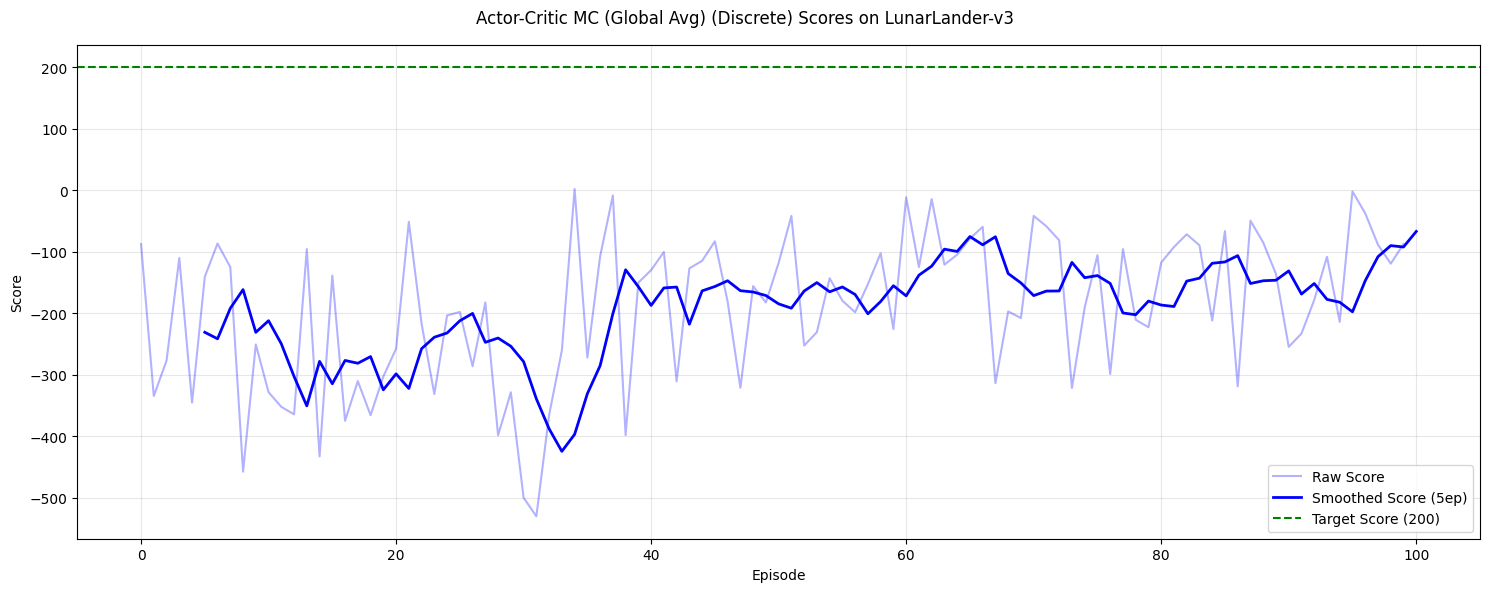

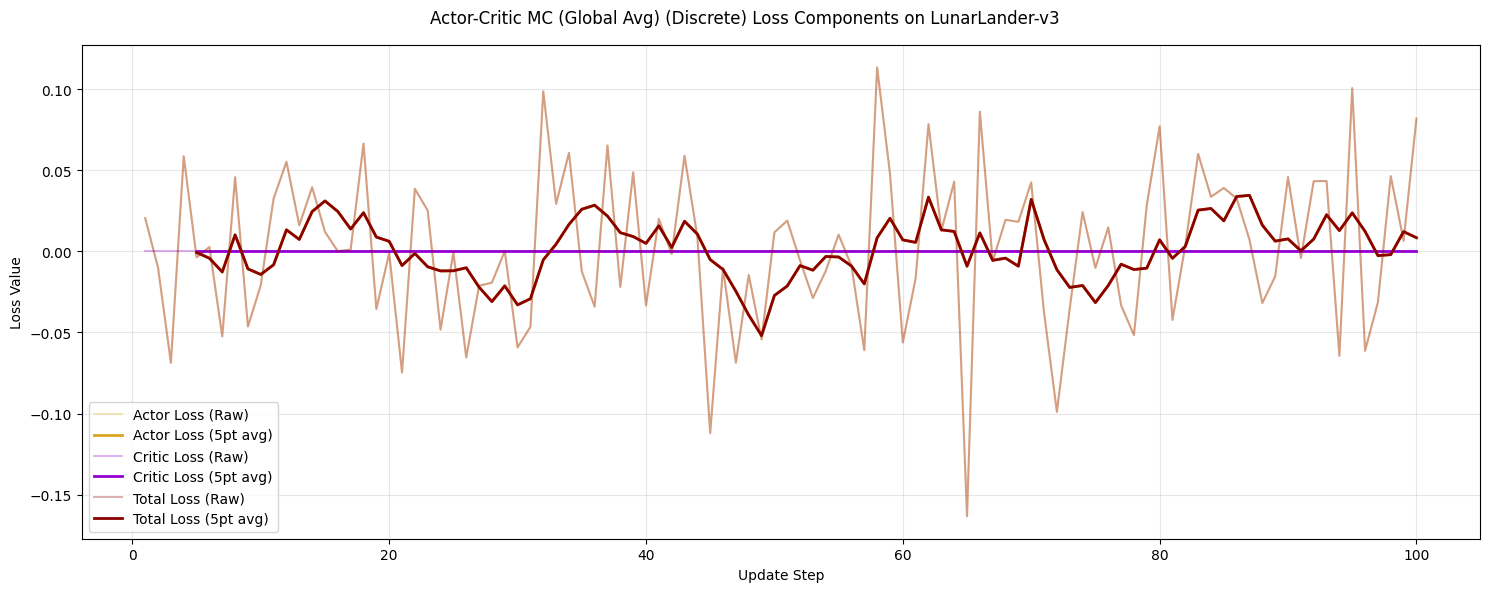

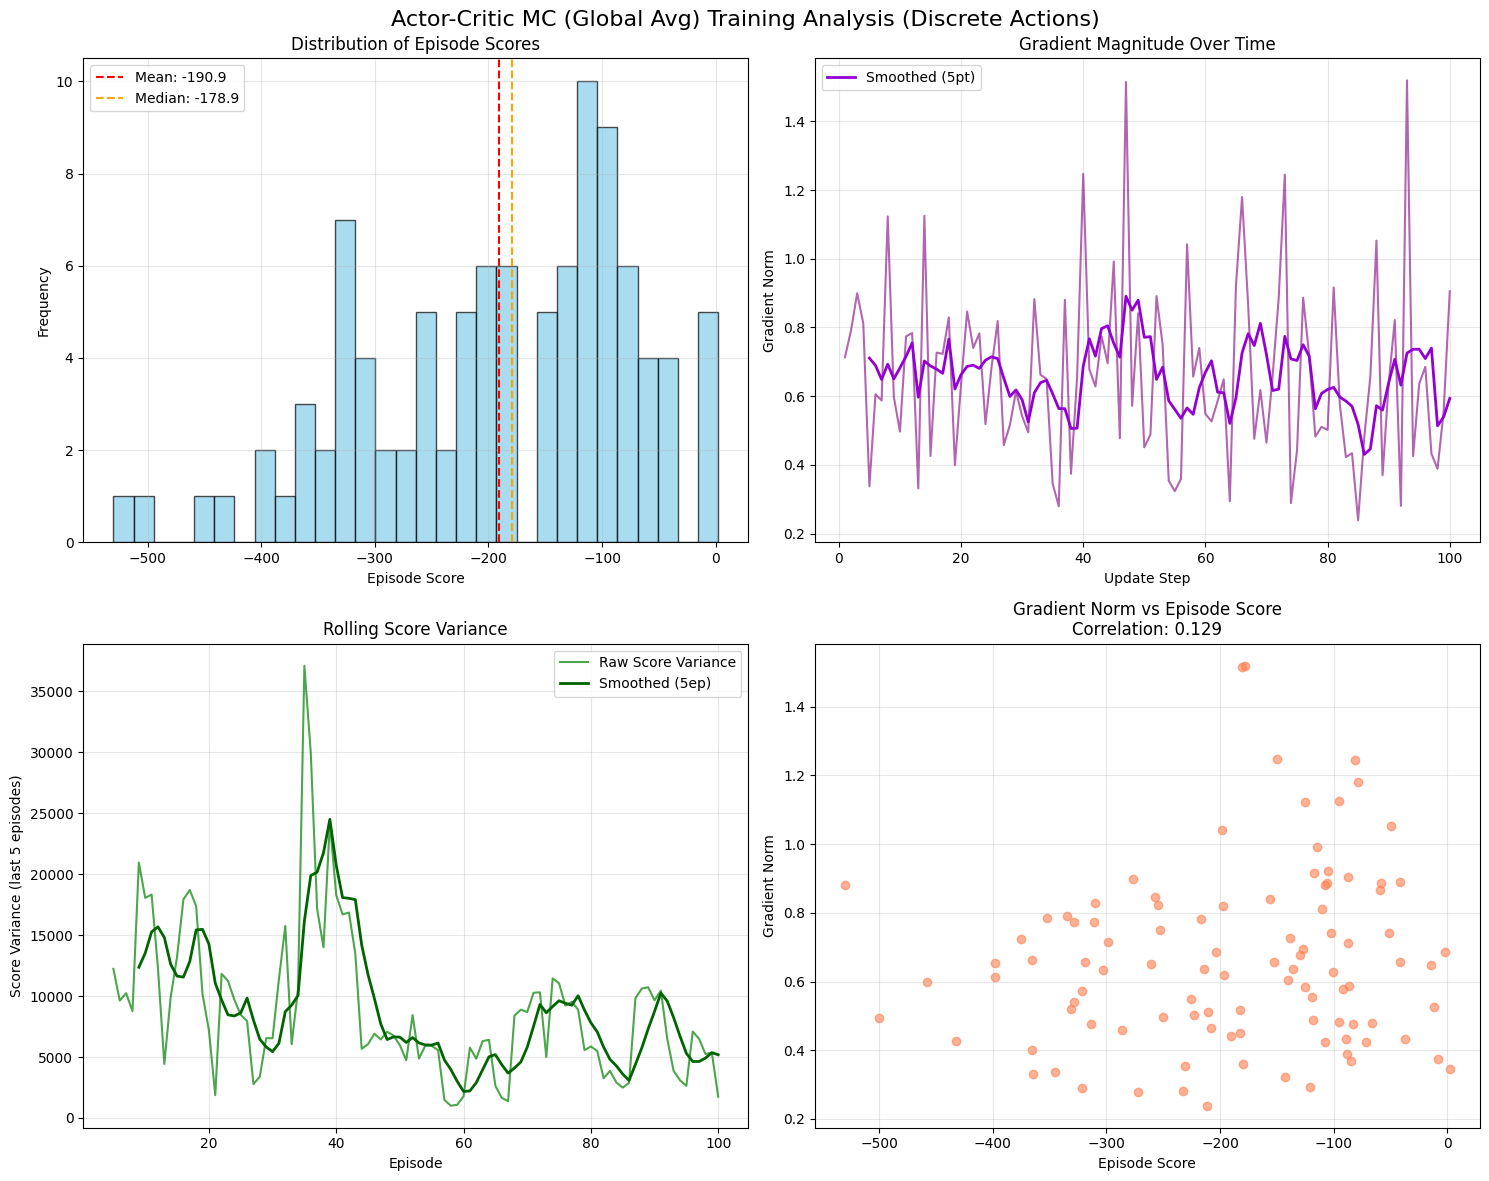


--- Actor-Critic MC (Global Avg) Training Statistics (Discrete) ---
Episode Scores: μ=-190.90, σ=119.60
Episode Returns (G_0): μ=-91.99, σ=61.57
Recent Score Variance: 1747.51
Recent Return Variance: 251.36
Gradient Norms: μ=0.6610, σ=0.2567
Total Update Steps: 100

✅ DISCRETE GLOBAL AVERAGE TRAINING COMPLETED!
Final average score (last 5 episodes): -66.82
Network parameters: 9,445
Global return average used as baseline: -91.99


In [5]:
# Plot results for discrete global average baseline
plot_training_results(
    discrete_global_scores, 
    discrete_global_agent.loss_history, 
    CONFIG, 
    "Discrete", 
    algorithm_name="Actor-Critic MC (Global Avg)"
)

# Show variance analysis
plot_variance_analysis(
    discrete_global_agent, 
    discrete_global_scores, 
    "Discrete", 
    CONFIG, 
    algorithm_name="Actor-Critic MC (Global Avg)"
)

# Training completion message
final_window_size = min(CONFIG["window_length"], len(discrete_global_scores))
final_avg = np.mean(discrete_global_scores[-final_window_size:]) if final_window_size > 0 else 0.0
print(f"\n✅ DISCRETE GLOBAL AVERAGE TRAINING COMPLETED!")
print(f"Final average score (last {final_window_size} episodes): {final_avg:.2f}")
print(f"Network parameters: {discrete_global_agent.network.get_param_count():,}")
print(f"Global return average used as baseline: {discrete_global_agent.global_return_average:.2f}")

In [6]:
# --- DISCRETE ACTION SPACE: VALUE FUNCTION BASELINE ---
print("Starting Actor-Critic MC training with DISCRETE actions and VALUE FUNCTION baseline...")

discrete_value_scores, discrete_value_losses, discrete_value_agent = train_actor_critic_mc(
    is_continuous=False, 
    config=CONFIG, 
    baseline_type="value_function"
)



📹 Displaying 9 training videos (episodes: [10, 21, 32, 43, 54, 65, 76, 87, 98]):


Ep   99 | Score: -213.9 | AvgScore(5): -145.2 | ActorLoss: -0.0441 | CriticLoss:  1.2788 | TotalLoss:  0.5953 | GradNorm: 3.5065:  99%|█████████▉| 99/100 [00:31<00:00,  2.39episode/s]

📹 9 training videos available in videos/ActorCritic_MC_discrete_value_function


Ep  100 | Score: -292.9 | AvgScore(5): -164.6 | ActorLoss: -0.0054 | CriticLoss:  0.6722 | TotalLoss:  0.3307 | GradNorm: 2.8237: 100%|██████████| 100/100 [00:32<00:00,  3.11episode/s]


Discrete training completed in 32.2 seconds!
Final performance: -164.61 (last 5 episodes)


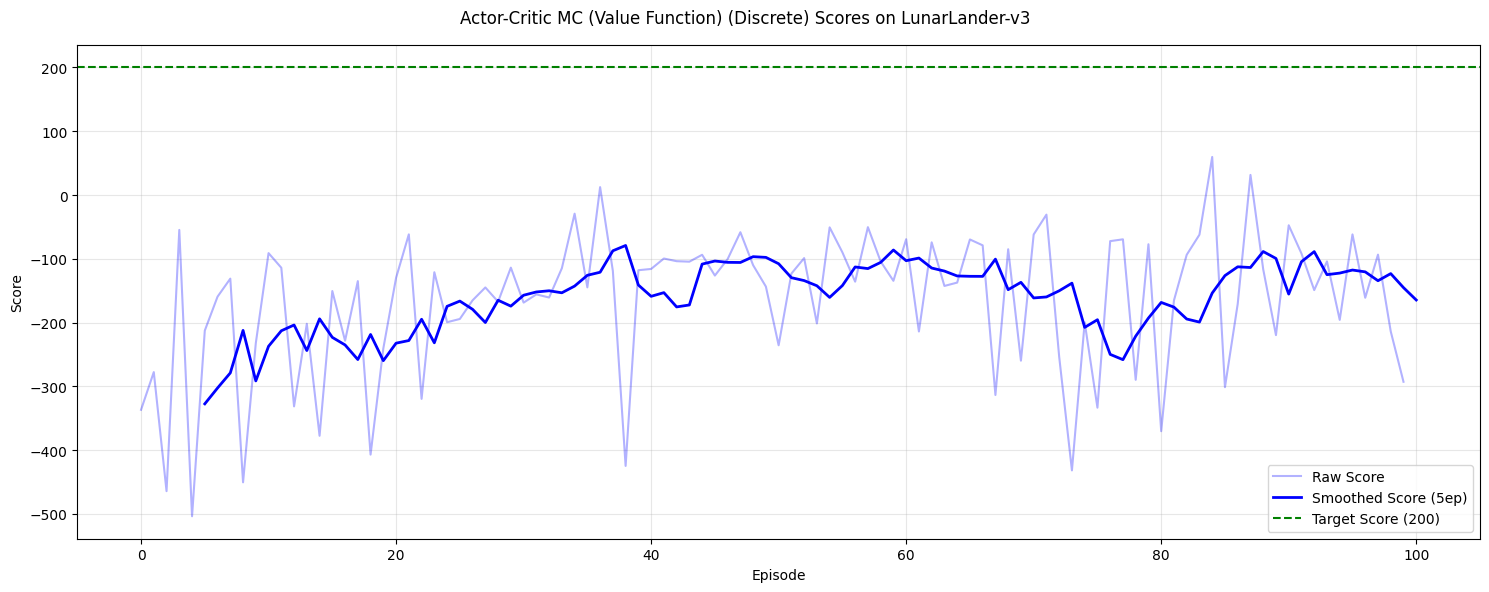

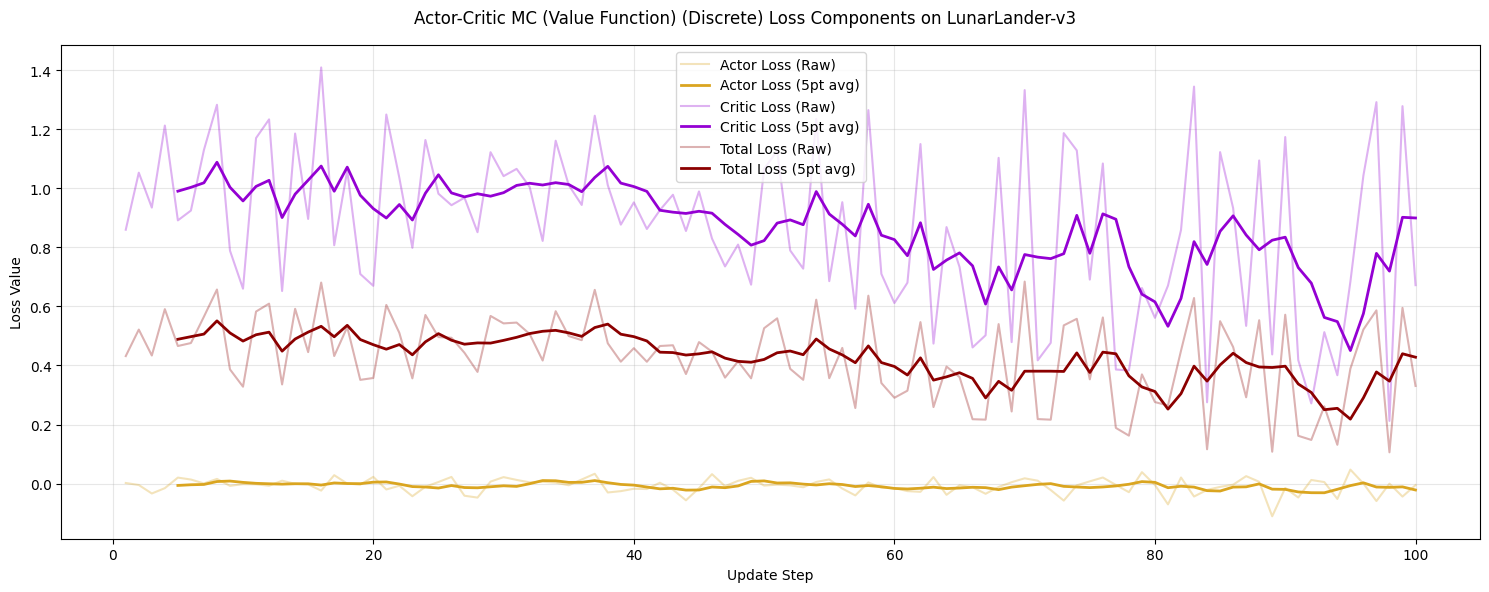

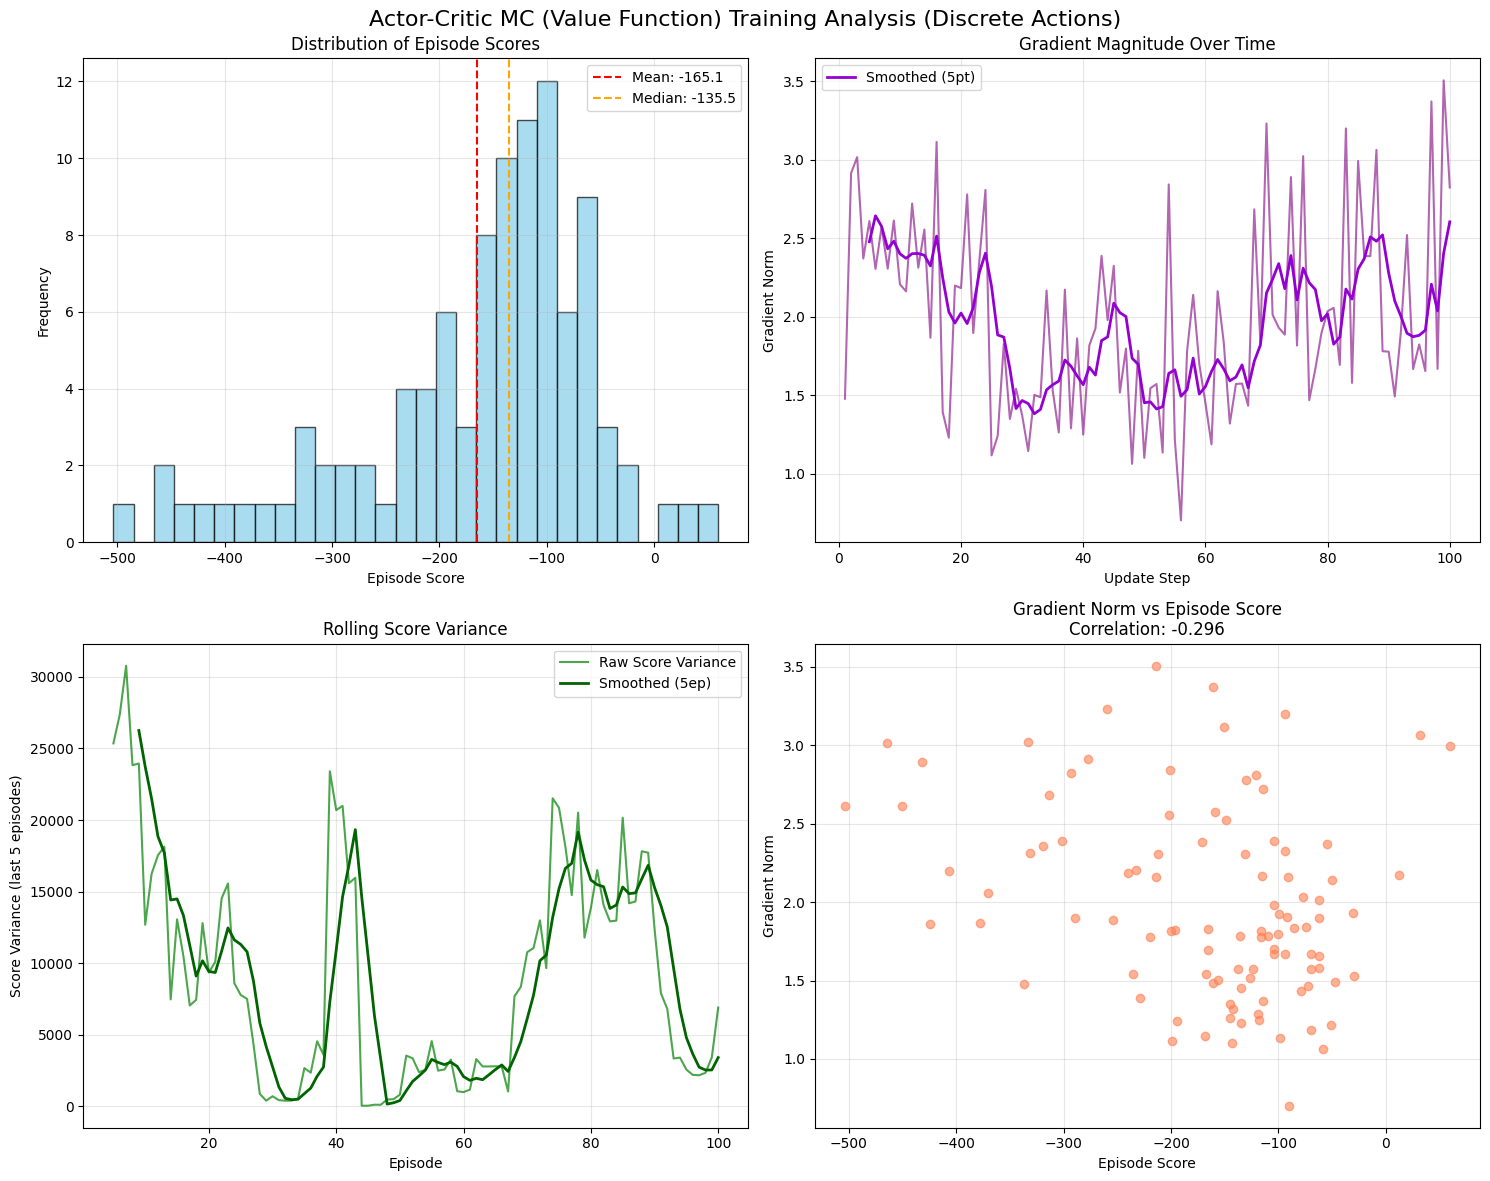


--- Actor-Critic MC (Value Function) Training Statistics (Discrete) ---
Episode Scores: μ=-165.08, σ=111.33
Episode Returns (G_0): μ=-75.87, σ=52.26
Recent Score Variance: 6905.35
Recent Return Variance: 554.05
Gradient Norms: μ=1.9864, σ=0.6071
Total Update Steps: 100

✅ DISCRETE VALUE FUNCTION TRAINING COMPLETED!
Final average score (last 5 episodes): -164.61
Network parameters: 9,445


In [7]:
# Plot results for discrete value function baseline
plot_training_results(
    discrete_value_scores, 
    discrete_value_agent.loss_history, 
    CONFIG, 
    "Discrete", 
    algorithm_name="Actor-Critic MC (Value Function)"
)

# Show variance analysis
plot_variance_analysis(
    discrete_value_agent, 
    discrete_value_scores, 
    "Discrete", 
    CONFIG, 
    algorithm_name="Actor-Critic MC (Value Function)"
)

# Training completion message
final_window_size = min(CONFIG["window_length"], len(discrete_value_scores))
final_avg = np.mean(discrete_value_scores[-final_window_size:]) if final_window_size > 0 else 0.0
print(f"\n✅ DISCRETE VALUE FUNCTION TRAINING COMPLETED!")
print(f"Final average score (last {final_window_size} episodes): {final_avg:.2f}")
print(f"Network parameters: {discrete_value_agent.network.get_param_count():,}")

In [8]:
# --- CONTINUOUS ACTION SPACE: GLOBAL AVERAGE BASELINE ---
print("Starting Actor-Critic MC training with CONTINUOUS actions and GLOBAL AVERAGE baseline...")

continuous_global_scores, continuous_global_losses, continuous_global_agent = train_actor_critic_mc(
    is_continuous=True, 
    config=CONFIG, 
    baseline_type="global_average"
)


📹 Displaying 9 training videos (episodes: [10, 21, 32, 43, 54, 65, 76, 87, 98]):


Ep   99 | Score: -284.8 | AvgScore(5): -216.1 | ActorLoss: -0.0095 | CriticLoss:  0.0000 | TotalLoss: -0.0095 | GradNorm: 0.5518:  99%|█████████▉| 99/100 [00:44<00:01,  1.02s/episode]

📹 9 training videos available in videos/ActorCritic_MC_continuous_global_average


Ep  100 | Score: -255.4 | AvgScore(5): -220.2 | ActorLoss:  0.0572 | CriticLoss:  0.0000 | TotalLoss:  0.0572 | GradNorm: 0.7870: 100%|██████████| 100/100 [00:45<00:00,  2.21episode/s]


Continuous training completed in 45.2 seconds!
Final performance: -220.15 (last 5 episodes)


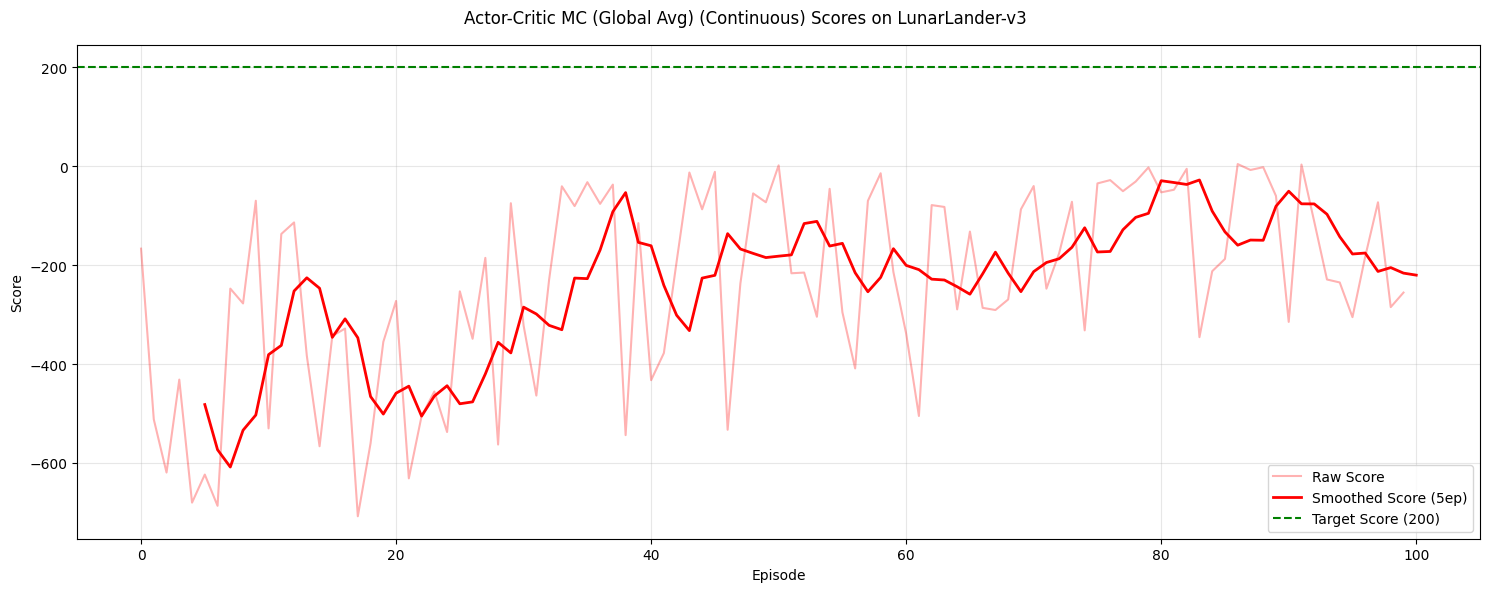

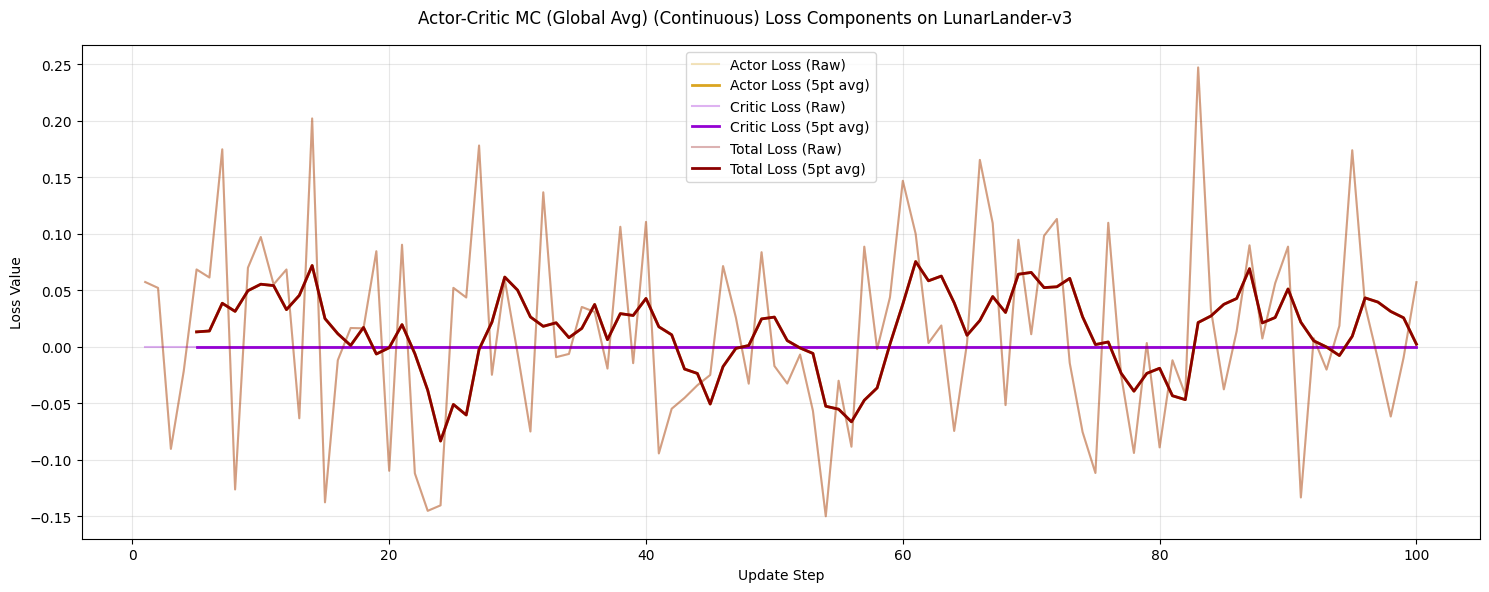

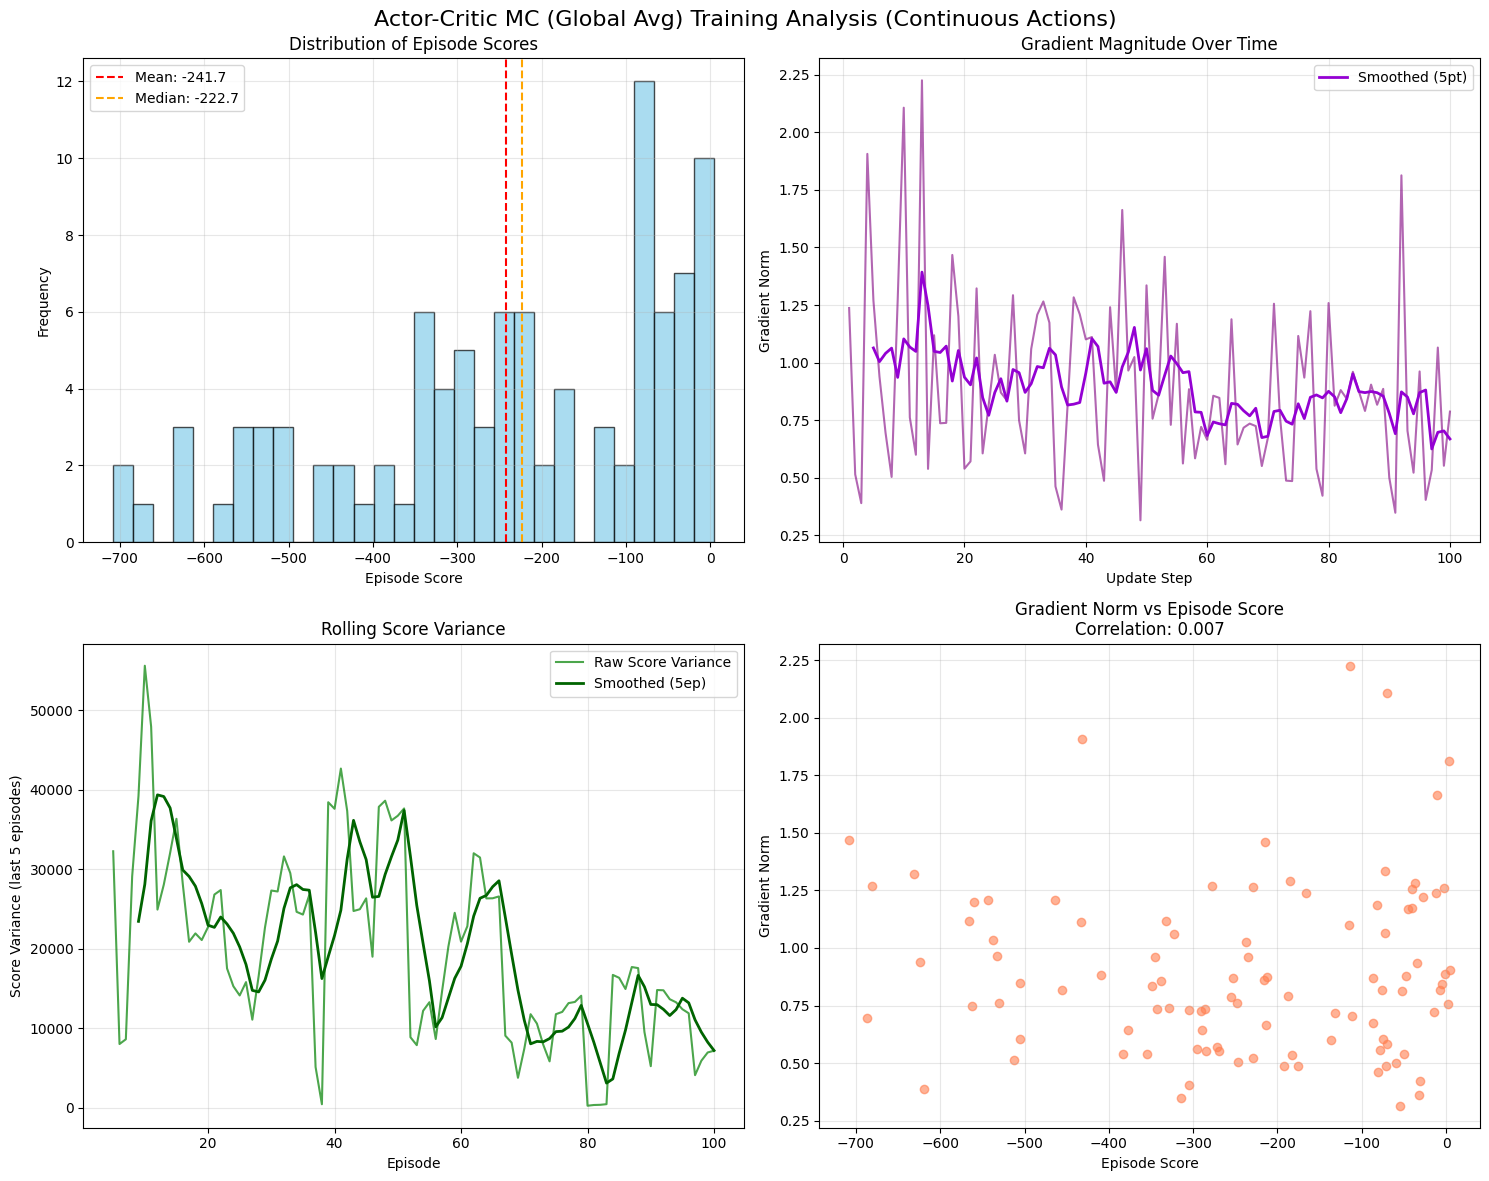


--- Actor-Critic MC (Global Avg) Training Statistics (Continuous) ---
Episode Scores: μ=-241.73, σ=193.91
Episode Returns (G_0): μ=-86.22, σ=94.85
Recent Score Variance: 7160.10
Recent Return Variance: 1229.96
Gradient Norms: μ=0.8937, σ=0.3724
Total Update Steps: 100

✅ CONTINUOUS GLOBAL AVERAGE TRAINING COMPLETED!
Final average score (last 5 episodes): -220.15
Network parameters: 9,381
Global return average used as baseline: -86.22


In [9]:
# Plot results for continuous global average baseline
plot_training_results(
    continuous_global_scores, 
    continuous_global_agent.loss_history, 
    CONFIG, 
    "Continuous", 
    algorithm_name="Actor-Critic MC (Global Avg)"
)

# Show variance analysis
plot_variance_analysis(
    continuous_global_agent, 
    continuous_global_scores, 
    "Continuous", 
    CONFIG, 
    algorithm_name="Actor-Critic MC (Global Avg)"
)

# Training completion message
final_window_size = min(CONFIG["window_length"], len(continuous_global_scores))
final_avg = np.mean(continuous_global_scores[-final_window_size:]) if final_window_size > 0 else 0.0
print(f"\n✅ CONTINUOUS GLOBAL AVERAGE TRAINING COMPLETED!")
print(f"Final average score (last {final_window_size} episodes): {final_avg:.2f}")
print(f"Network parameters: {continuous_global_agent.network.get_param_count():,}")
print(f"Global return average used as baseline: {continuous_global_agent.global_return_average:.2f}")

In [10]:
# --- CONTINUOUS ACTION SPACE: VALUE FUNCTION BASELINE ---
print("Starting Actor-Critic MC training with CONTINUOUS actions and VALUE FUNCTION baseline...")

continuous_value_scores, continuous_value_losses, continuous_value_agent = train_actor_critic_mc(
    is_continuous=True, 
    config=CONFIG, 
    baseline_type="value_function"
)


📹 Displaying 9 training videos (episodes: [10, 21, 32, 43, 54, 65, 76, 87, 98]):


Ep   99 | Score: -235.2 | AvgScore(5): -298.6 | ActorLoss:  0.2383 | CriticLoss:  0.2702 | TotalLoss:  0.3733 | GradNorm: 1.4775:  99%|█████████▉| 99/100 [00:35<00:00,  1.53episode/s]

📹 9 training videos available in videos/ActorCritic_MC_continuous_value_function


Ep  100 | Score: -245.8 | AvgScore(5): -262.2 | ActorLoss:  0.0149 | CriticLoss:  1.9844 | TotalLoss:  1.0070 | GradNorm: 6.3061: 100%|██████████| 100/100 [00:35<00:00,  2.78episode/s]


Continuous training completed in 35.9 seconds!
Final performance: -262.17 (last 5 episodes)


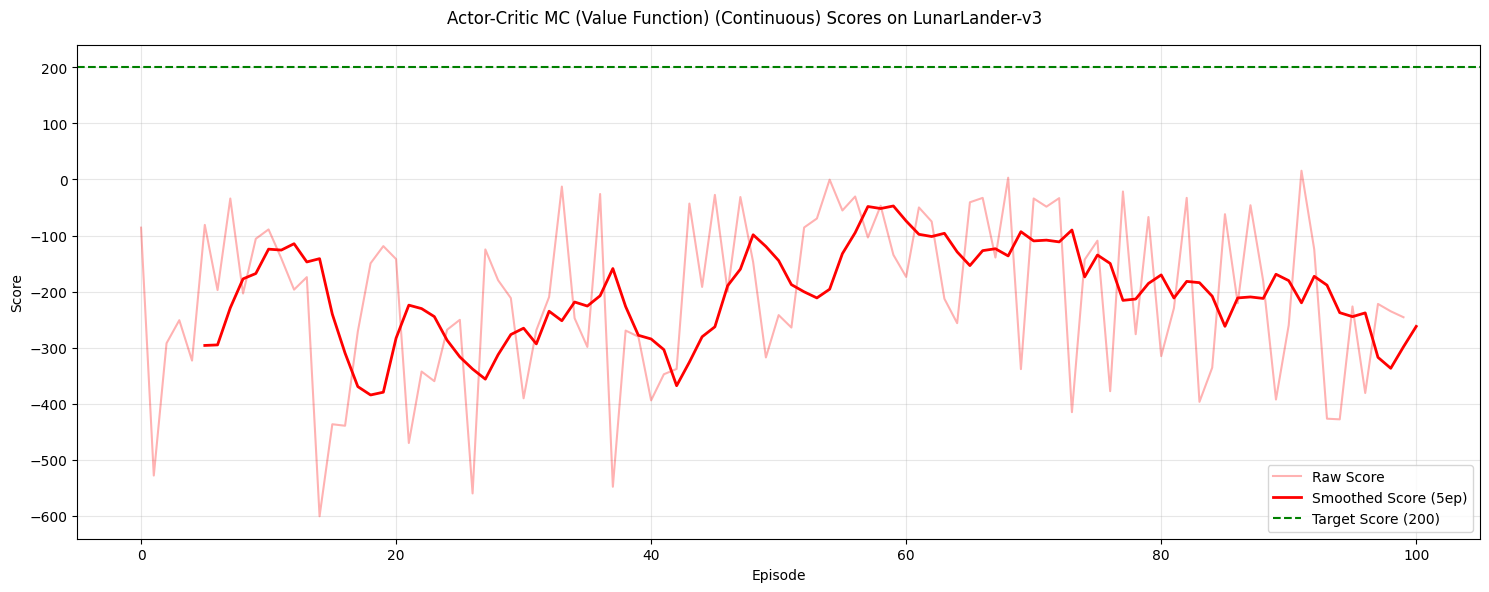

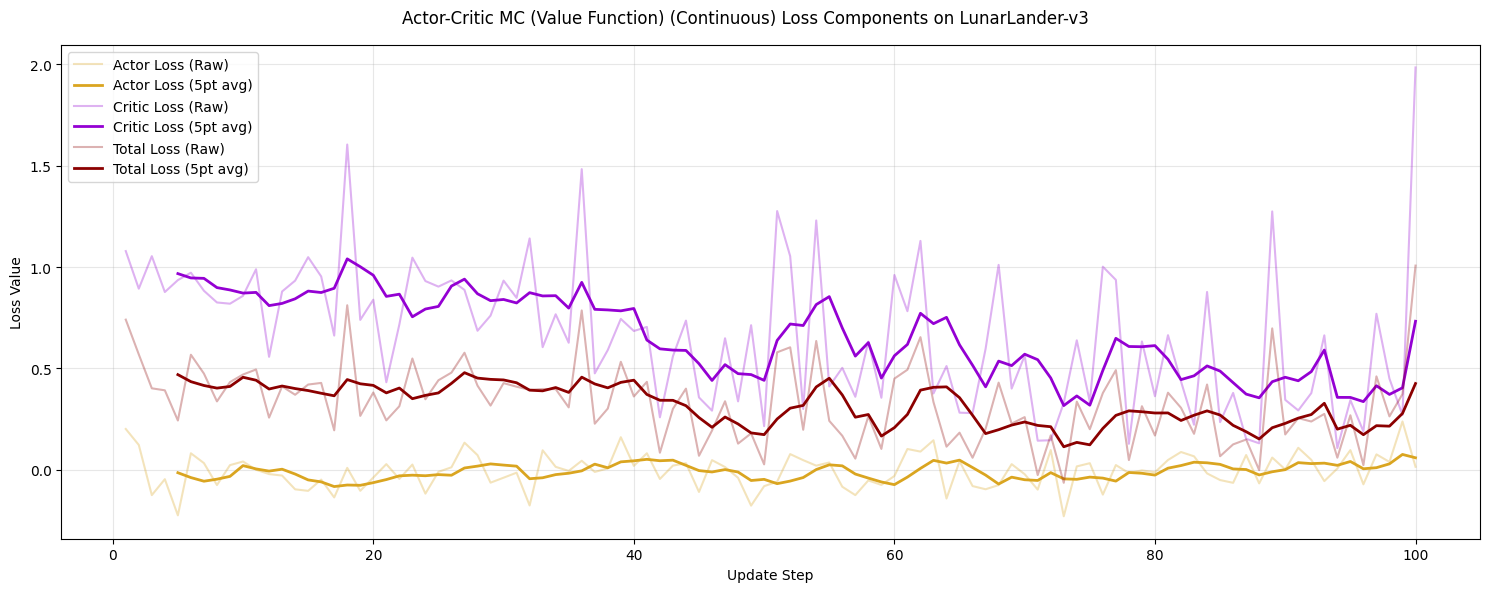

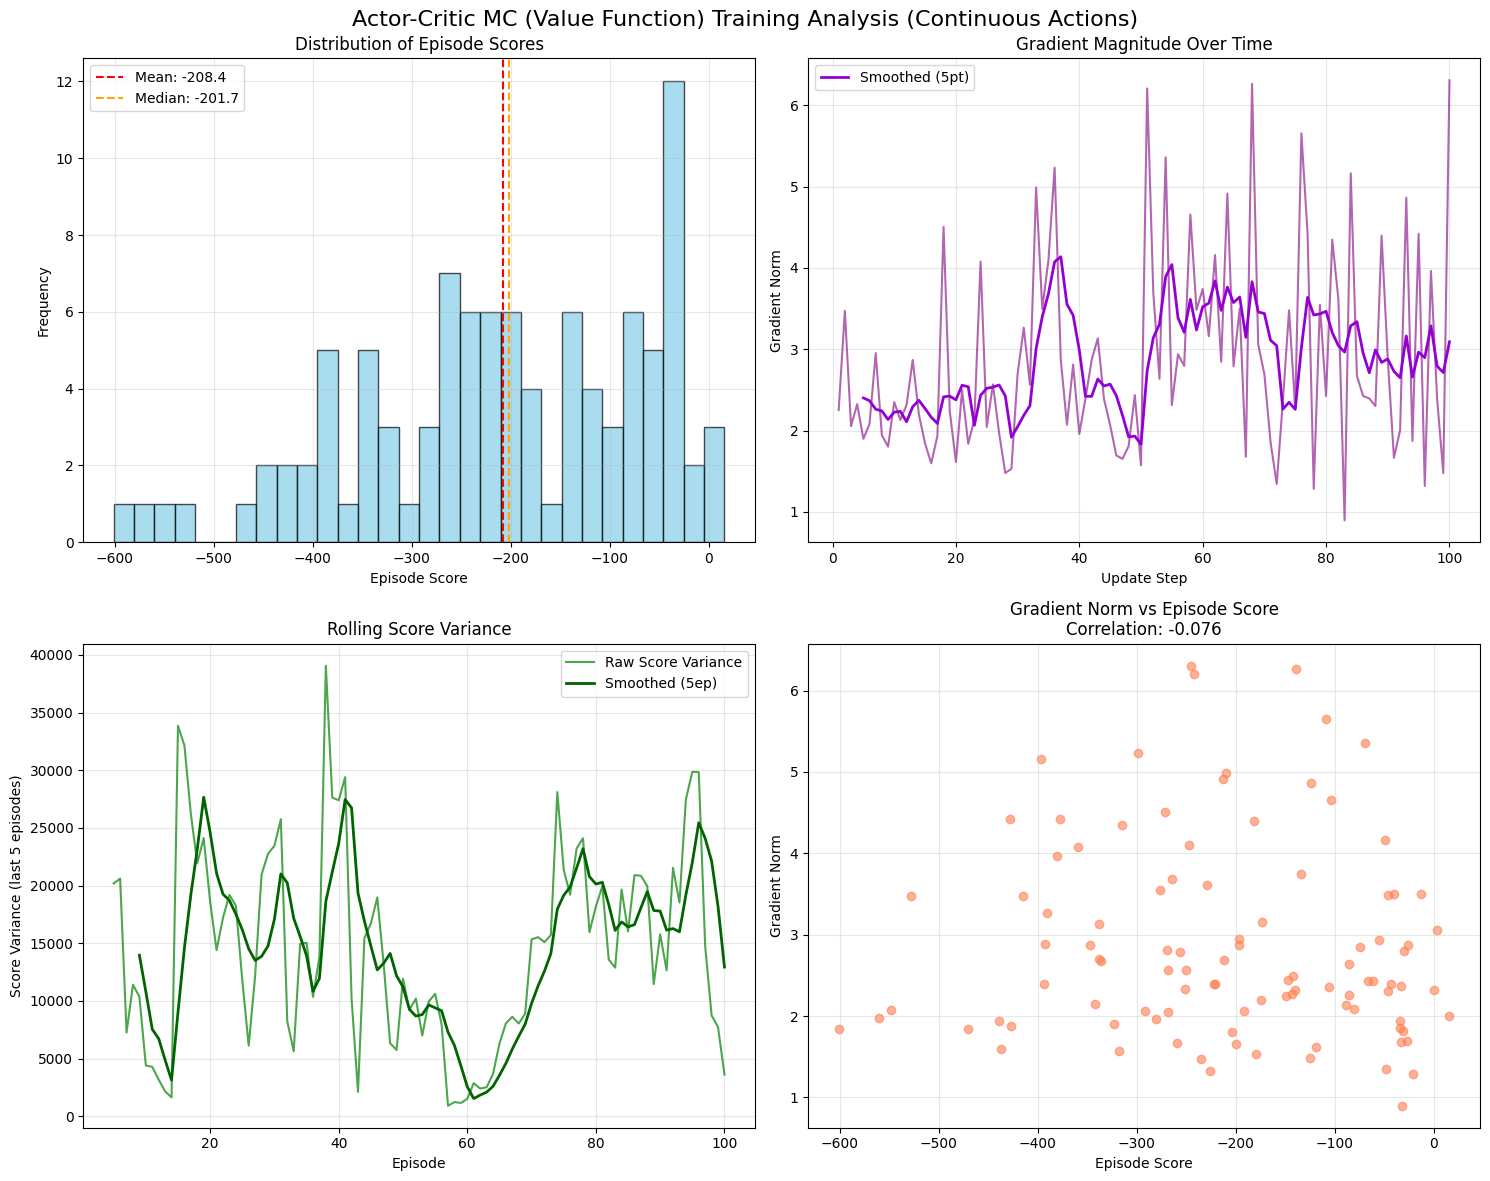


--- Actor-Critic MC (Value Function) Training Statistics (Continuous) ---
Episode Scores: μ=-208.44, σ=145.37
Episode Returns (G_0): μ=-63.12, σ=54.76
Recent Score Variance: 3600.33
Recent Return Variance: 636.11
Gradient Norms: μ=2.8755, σ=1.2088
Total Update Steps: 100

✅ CONTINUOUS VALUE FUNCTION TRAINING COMPLETED!
Final average score (last 5 episodes): -262.17
Network parameters: 9,381


In [11]:
# Plot results for continuous value function baseline
plot_training_results(
    continuous_value_scores, 
    continuous_value_agent.loss_history, 
    CONFIG, 
    "Continuous", 
    algorithm_name="Actor-Critic MC (Value Function)"
)

# Show variance analysis
plot_variance_analysis(
    continuous_value_agent, 
    continuous_value_scores, 
    "Continuous", 
    CONFIG, 
    algorithm_name="Actor-Critic MC (Value Function)"
)

# Training completion message
final_window_size = min(CONFIG["window_length"], len(continuous_value_scores))
final_avg = np.mean(continuous_value_scores[-final_window_size:]) if final_window_size > 0 else 0.0
print(f"\n✅ CONTINUOUS VALUE FUNCTION TRAINING COMPLETED!")
print(f"Final average score (last {final_window_size} episodes): {final_avg:.2f}")
print(f"Network parameters: {continuous_value_agent.network.get_param_count():,}")


COMPREHENSIVE ANALYSIS: Actor-Critic MC Baseline Comparison

📊 FINAL PERFORMANCE COMPARISON (last 5 episodes):
Method                    Final Score  Score Std  Grad Std   Updates  Up/Ep    Parameters  
-----------------------------------------------------------------------------------------------
Discrete Global Avg       -66.8        119.6      0.2567     100      1.0      9,445       
Discrete Value Func       -164.6       111.3      0.6071     100      1.0      9,445       
Continuous Global Avg     -220.2       193.9      0.3724     100      1.0      9,381       
Continuous Value Func     -262.2       145.4      1.2088     100      1.0      9,381       

📈 BASELINE EFFECTIVENESS ANALYSIS:
Discrete Global Avg:
  Final score variance (last 5 episodes): 1747.5
  Advantage: μ= 13.63, σ= 61.35
  Baseline: μ=-115.8
Discrete Value Func:
  Final score variance (last 5 episodes): 6905.3
  Advantage: μ=  0.01, σ=  0.95
  Baseline: μ=  -0.0
Continuous Global Avg:
  Final score variance (las

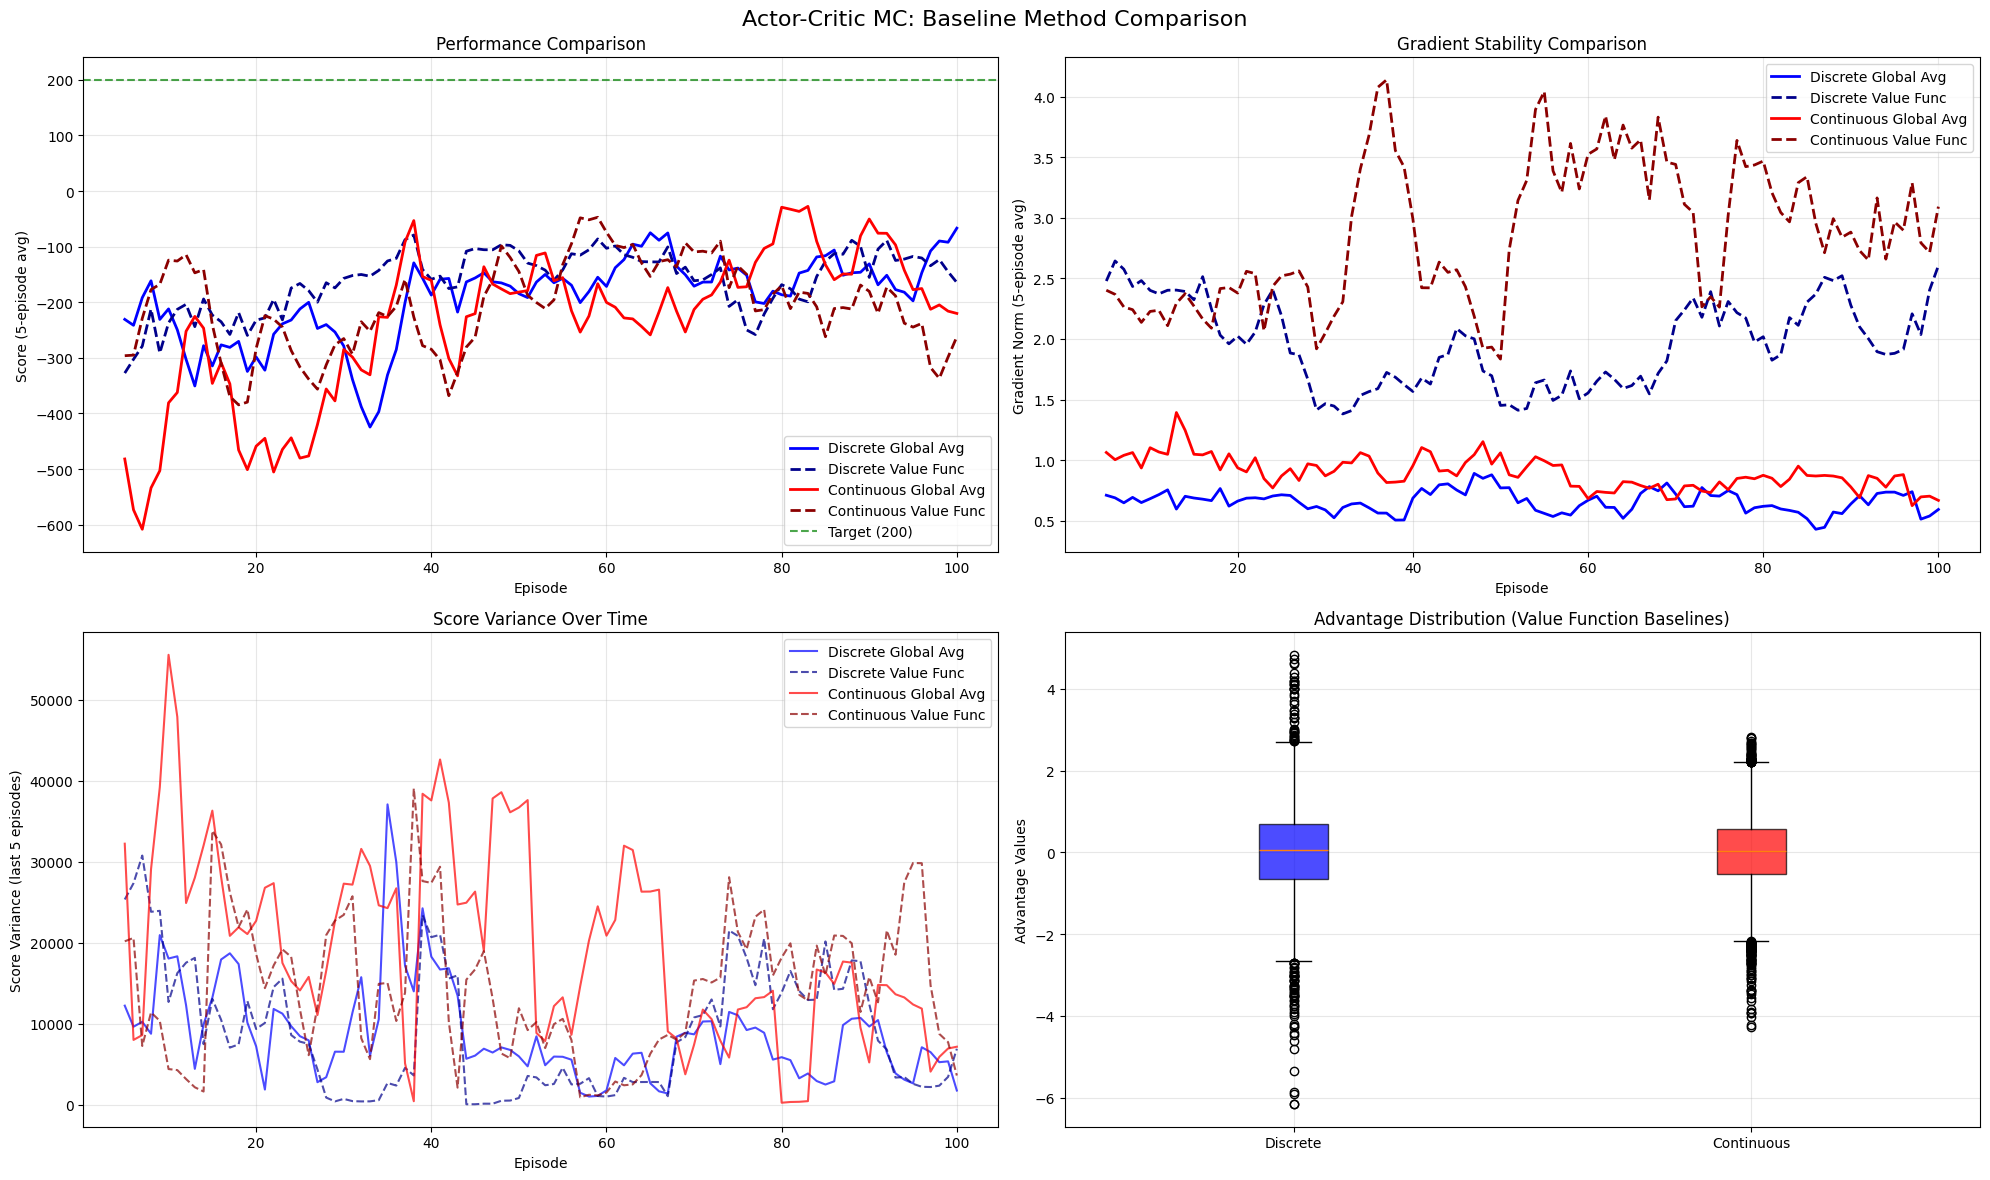

In [12]:
# --- COMPREHENSIVE ANALYSIS: Actor-Critic MC Baseline Comparison ---
import matplotlib.pyplot as plt
from rl_utils.visualization import get_moving_average

print(f"\n{'='*80}")
print(f"COMPREHENSIVE ANALYSIS: Actor-Critic MC Baseline Comparison")
print(f"{'='*80}")

# Collect all experiment results
experiments = [
    ("Discrete Global Avg", discrete_global_scores, discrete_global_agent),
    ("Discrete Value Func", discrete_value_scores, discrete_value_agent),
    ("Continuous Global Avg", continuous_global_scores, continuous_global_agent),
    ("Continuous Value Func", continuous_value_scores, continuous_value_agent),
]

print(f"\n📊 FINAL PERFORMANCE COMPARISON (last {CONFIG['window_length']} episodes):")
print(f"{'Method':<25} {'Final Score':<12} {'Score Std':<10} {'Grad Std':<10} {'Updates':<8} {'Up/Ep':<8} {'Parameters':<12}")
print("-" * 95)

for name, scores, agent in experiments:
    final_window_size = min(CONFIG["window_length"], len(scores))
    final_score = np.mean(scores[-final_window_size:]) if final_window_size > 0 else 0.0
    stats = agent.get_variance_stats()
    
    # Calculate updates per episode
    total_updates = getattr(agent, 'update_step', len(scores))
    updates_per_episode = total_updates / len(scores) if len(scores) > 0 else 0.0
    param_count = agent.network.get_param_count()
    
    print(f"{name:<25} {final_score:<12.1f} {stats['score_std']:<10.1f} {stats['gradient_norm_std']:<10.4f} {total_updates:<8} {updates_per_episode:<8.1f} {param_count:<12,}")

print(f"\n📈 BASELINE EFFECTIVENESS ANALYSIS:")
for name, scores, agent in experiments:
    stats = agent.get_variance_stats()
    recent_score_var = stats.get('recent_score_variance', 0.0)
    recent_return_var = stats.get('recent_return_variance', 0.0)
    
    # Calculate baseline statistics
    if hasattr(agent, 'advantages') and len(agent.advantages) > 0:
        adv_mean = np.mean(agent.advantages)
        adv_std = np.std(agent.advantages)
        baseline_mean = np.mean(agent.baselines_used) if hasattr(agent, 'baselines_used') else 0.0
        
        print(f"{name}:")
        print(f"  Final score variance (last {CONFIG['window_length']} episodes): {recent_score_var:.1f}")
        print(f"  Advantage: μ={adv_mean:6.2f}, σ={adv_std:6.2f}")
        print(f"  Baseline: μ={baseline_mean:6.1f}")

# Create comprehensive comparison plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Actor-Critic MC: Baseline Method Comparison', fontsize=16)

colors = ['blue', 'darkblue', 'red', 'darkred']
line_styles = ['-', '--', '-', '--']
smoothing_window = CONFIG["window_length"]

# 1. Performance comparison
for i, (name, scores, agent) in enumerate(experiments):
    if len(scores) >= smoothing_window:
        smoothed, offset = get_moving_average(scores, window=smoothing_window)
        episodes = range(offset + 1, offset + 1 + len(smoothed))
        ax1.plot(episodes, smoothed, label=name, color=colors[i], linewidth=2, linestyle=line_styles[i])

ax1.axhline(y=CONFIG["target_score"], color='g', linestyle='--', label=f'Target ({CONFIG["target_score"]})', alpha=0.7)
ax1.set_xlabel('Episode')
ax1.set_ylabel(f'Score ({smoothing_window}-episode avg)')
ax1.set_title('Performance Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Gradient stability comparison
for i, (name, scores, agent) in enumerate(experiments):
    if len(agent.gradient_norms) >= smoothing_window:
        smoothed, offset = get_moving_average(agent.gradient_norms, window=smoothing_window)
        episodes = range(offset + 1, offset + 1 + len(smoothed))
        ax2.plot(episodes, smoothed, label=name, color=colors[i], linewidth=2, linestyle=line_styles[i])

ax2.set_xlabel('Episode')
ax2.set_ylabel(f'Gradient Norm ({smoothing_window}-episode avg)')
ax2.set_title('Gradient Stability Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Score variance over time
for i, (name, scores, agent) in enumerate(experiments):
    if len(agent.score_variance_history) > 0:
        variance_start = CONFIG["window_length"]
        variance_episodes = range(variance_start, variance_start + len(agent.score_variance_history))
        ax3.plot(variance_episodes, agent.score_variance_history, label=name, color=colors[i], alpha=0.7, linestyle=line_styles[i])

ax3.set_xlabel('Episode')
ax3.set_ylabel(f'Score Variance (last {CONFIG["window_length"]} episodes)')
ax3.set_title('Score Variance Over Time')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Advantage distribution comparison (for value function baselines)
value_func_experiments = [(name, scores, agent) for name, scores, agent in experiments if "Value Func" in name]
if value_func_experiments:
    advantage_data = []
    labels = []
    colors_subset = []
    
    for i, (name, scores, agent) in enumerate(value_func_experiments):
        if hasattr(agent, 'advantages') and len(agent.advantages) > 0:
            advantage_data.append(agent.advantages)
            labels.append(name.replace(' Value Func', '').replace(' ', '\n'))
            colors_subset.append('blue' if 'Discrete' in name else 'red')
    
    if advantage_data:
        box_plot = ax4.boxplot(advantage_data, tick_labels=labels, patch_artist=True)
        for patch, color in zip(box_plot['boxes'], colors_subset):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax4.set_ylabel('Advantage Values')
        ax4.set_title('Advantage Distribution (Value Function Baselines)')
        ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()